# Trump Tweets

This the data behind the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/).

In [2]:
# The usual suspects ...
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time_series as ts

# And their accomplices ...
from scipy import stats
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint

# Settings
sns.set_style('white')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Getting the data
df = pd.read_csv('data/realDonaldTrump_poll_tweets.csv')

In [4]:
# Size
df.shape

(448, 3)

In [5]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


#### Preprocessing

In [6]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

In [7]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, '')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0           Its just a 2point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17Point Positive Swing ...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

In [9]:
# Emoticons and emojis
# HappyEmoticons
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                       ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                       '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                       'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                       '<3'])

# Sad Emoticons
emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                     ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                     ':c', ':{', '>:\\', ';('])

# Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

# Combine
emoticons = emoticons_happy.union(emoticons_sad)

In [12]:
# Text corpus
document = [i for i in df['text']]

# Removing common words and tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',
                   'amp', 'kkk', 'hahaha', 'haha', 'ha'])
for doc in document:
    list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
stop_words.update(list_of_words)

# Removing common words
texts = [[word for word in doc.lower().split() if word not in stop_words] for doc in document]

# Removing words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

# Removing empty tokens
texts = [text for text in texts if len(text) > 1]

# Removing emojis
texts = [[token for token in text if token not in emoticons] for text in texts]

# Printing the top 10
#pprint(texts[:10])

#### Transformation: Document dictionary

In [13]:
# Create dictionary of document
bag = corpora.Dictionary(texts)
bag.save('models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('models/trump.mm', corpus)

We have assigned a unique integer id to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts and relevant statistics
   
Our corpus is a 448 x 661 matrix.

***

#### Transformation: _tf-idf_

#### Step 1:

In [14]:
# Initialization
tfidf = models.TfidfModel(corpus)

We have initialized (trained) a transaformation model. Different transformation may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features. This is in comparison to ___Latent Semantic Analysis___ & ___Latent Dirichlet Allocation___ which are more involved and take more time.

**A note on transaformations**:
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

#### Step 2:
From now on, ___tf-idf___ is treated as a read-only object that can be used to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights).

In [15]:
# Applying the transformation to the whole corpus
corpus_tfidf = tfidf[corpus]

We have transformed our corpus (the one we used for training) into a weighted vector. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___.

#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent 10-D space (... num_topics = 10).

In [16]:
# Initializing an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lsi = lsi[corpus_tfidf]

In [17]:
lsi.print_topics()

[(0,
  '-0.587*"thank" + -0.417*"new" + -0.409*"great" + -0.209*"poll" + -0.156*"america" + -0.148*"numbers" + -0.132*"iowa" + -0.116*"reuters" + -0.106*"trump" + -0.103*"support"'),
 (1,
  '-0.444*"thank" + 0.339*"trump" + 0.215*"donald" + 0.199*"lead" + 0.195*"carson" + 0.191*"leads" + 0.188*"rubio" + 0.174*"national" + 0.172*"cruz" + 0.146*"debate"'),
 (2,
  '0.388*"great" + -0.274*"thank" + 0.231*"numbers" + 0.231*"big" + 0.206*"america" + -0.202*"carson" + 0.189*"make" + 0.180*"debate" + -0.174*"rubio" + 0.158*"good"'),
 (3,
  '0.426*"great" + -0.385*"national" + 0.322*"leads" + -0.268*"iowa" + -0.212*"lead" + 0.193*"rubio" + -0.175*"released" + 0.162*"trump" + 0.154*"carson" + -0.149*"debate"'),
 (4,
  '0.416*"debate" + -0.333*"national" + 0.253*"thank" + 0.242*"said" + -0.207*"new" + -0.185*"leads" + -0.162*"america" + 0.143*"carson" + 0.142*"every" + 0.138*"winning"')]

#### Topics

According to ___LSI___:
<br>
**Topic 1**
> References poll numbers, Iowa, Reuters and Trump.

**Topic 2**
> References Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.

**Topic 3**
> References debate, Carson, and Rubio hinting at what these individuals may have said in the debate.

**Topic 4**
> References great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.

**Topic 5**
> References similar words as topic 4.

In [18]:
# Model persistence: save(), load()
lsi.save('models/trump.lsi')
lsi = models.LsiModel.load('models/trump.lsi')

***
### Similarity

#### Step 1:

In [19]:
# Initializing the query structure: transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corpus])

# Index persistence
index.save('models/trump.index')
index = similarities.MatrixSimilarity.load('models/trump.index')

#### Step 2:

In [20]:
def query_similarity(doc, index=index):
    
    # Performing queries
    vec_bow = bag.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec_lsi = lsi[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec_lsi]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(10):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], document[sims[i][0]]))

In [21]:
query_similarity(doc='Hillary Clinton', index=index)

Tweet Rank #1:	Weight: 0.9858073592185974
Raw text: Hillary Clinton is not a change agent just the same old status quo She is spending a fortune I am spending very little Close in polls

Tweet Rank #2:	Weight: 0.9752110242843628
Raw text: The refused to use their just in poll numbers where I have a massive lead but instead used numbers where my lead is smaller

Tweet Rank #3:	Weight: 0.974594235420227
Raw text: CNBC poll Trump won

Tweet Rank #4:	Weight: 0.9676651358604431
Raw text: Sickening attempt I hope jumps another 10 points

Tweet Rank #5:	Weight: 0.9664925932884216
Raw text: Ted Cruz didnt win Iowa he stole it That is why all of the polls were so wrong and why he got far more votes than anticipated Bad

Tweet Rank #6:	Weight: 0.9618586897850037
Raw text: Watch my interview on Face The Nation now and also the new CBS POLLS which if good for me the media wont report

Tweet Rank #7:	Weight: 0.9388235211372375
Raw text: RT Today we spoke with Donald Trump about his rising leads in 

When we make a query for "Hillary Clinton" to retrieve the respective top tweets associated with her name, we find that the leading tweet with the greatest weight is a strong criticism of Hillary Clinton and her campaign spending. The remaining nine tweets are associated with the polls, darted with references to Donald Trump criticizing poll results not in his favor, him leading against the opposition as well as pitting himself likely to win.

In [22]:
# Performing queries
query_similarity(doc="Ben Carson")

Tweet Rank #1:	Weight: 0.9963889718055725
Raw text: All seven online polls including Drudge and Time with thousands of respondents said I won the debate said I was so so

Tweet Rank #2:	Weight: 0.989972710609436
Raw text: Morning Consult poll Trump Leads

Tweet Rank #3:	Weight: 0.9861418604850769
Raw text: New CNNORC poll w 24 favorability rating on the rise while Jebs declines 60 among women

Tweet Rank #4:	Weight: 0.977210283279419
Raw text: Rasmussen now beats 3836 nationally

Tweet Rank #5:	Weight: 0.9750733375549316
Raw text: WSJNBC Poll Donald Trump Widens His Lead in Republican Presidential Race

Tweet Rank #6:	Weight: 0.967241644859314
Raw text: GREAT Video Which of these 4 Polls is Suspect Kudos to

Tweet Rank #7:	Weight: 0.9659504294395447
Raw text: Good morning America Thank you for all of your support in the latest Drudge poll

Tweet Rank #8:	Weight: 0.9644325971603394
Raw text: RT New poll finds lean Republicans think most likely to be GOP nominee and has best cha…

Tweet 

#### Transformation: LDA

In [23]:
# LDA Transformation
lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=5)
corpus_lda = lda[corpus_tfidf]

In [24]:
lda.print_topics()

[(0,
  '0.021*"great" + 0.018*"thank" + 0.016*"new" + 0.012*"national" + 0.011*"poll" + 0.011*"iowa" + 0.010*"trump" + 0.008*"lead" + 0.008*"donald" + 0.008*"good"'),
 (1,
  '0.010*"trump" + 0.009*"shows" + 0.009*"new" + 0.008*"nomination" + 0.008*"great" + 0.008*"america" + 0.007*"lead" + 0.007*"debate" + 0.007*"via" + 0.007*"big"'),
 (2,
  '0.013*"thank" + 0.011*"new" + 0.010*"reuters" + 0.010*"even" + 0.009*"great" + 0.009*"numbers" + 0.008*"poll" + 0.008*"trump" + 0.008*"5" + 0.007*"results"'),
 (3,
  '0.013*"trump" + 0.012*"new" + 0.010*"poll" + 0.010*"leads" + 0.009*"iowa" + 0.009*"win" + 0.009*"thank" + 0.008*"big" + 0.008*"hillary" + 0.008*"lead"'),
 (4,
  '0.018*"thank" + 0.017*"new" + 0.011*"poll" + 0.011*"hampshire" + 0.011*"trump" + 0.011*"great" + 0.009*"rubio" + 0.008*"cruz" + 0.008*"10" + 0.008*"wow"')]

In [25]:
# Visualizing LDA topic models
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
viz

/home/golix/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.008938 -0.049168       1        1  26.860895
0      0.040144 -0.002199       2        1  21.790270
3     -0.003725  0.057566       3        1  20.901329
1     -0.065342 -0.010150       4        1  17.698782
2      0.019985  0.003951       5        1  12.748716, topic_info=    Category       Freq        Term      Total  loglift  logprob
486  Default   7.000000  nomination   7.000000  30.0000  30.0000
163  Default   5.000000           5   5.000000  29.0000  29.0000
16   Default  12.000000        even  12.000000  28.0000  28.0000
102  Default  15.000000     reuters  15.000000  27.0000  27.0000
180  Default   6.000000           6   6.000000  26.0000  26.0000
146  Default   9.000000      really   9.000000  25.0000  25.0000
41   Default   9.000000        many   9.000000  24.0000  24.0000
57   Default  14.000000       shows  14.000000  23.0000  23.0000
150  Default   7.000000        head   7.000000  22.0000  22.0000
217  Default   8.000000         way   8.000000  21.0000  21.0000
66   Default   9.000000     results   9.000000  20.0000  20.0000
81   Default  16.000000         wow  16.000000  19.0000  19.0000
351  Default   5.000000   president   5.000000  18.0000  18.0000
170  Default  15.000000         via  15.000000  17.0000  17.0000
33   Default  10.000000     florida  10.000000  16.0000  16.0000
11   Default  47.000000       thank  47.000000  15.0000  15.0000
37   Default  13.000000         win  13.000000  14.0000  14.0000
7    Default  41.000000       great  41.000000  13.0000  13.0000
508  Default   5.000000       straw   5.000000  12.0000  12.0000
460  Default   7.000000      gravis   7.000000  11.0000  11.0000
166  Default   9.000000          12   9.000000  10.0000  10.0000
18   Default  14.000000     hillary  14.000000   9.0000   9.0000
240  Default  16.000000   hampshire  16.000000   8.0000   8.0000
171  Default  12.000000          10  12.000000   7.0000   7.0000
283  Default   6.000000    received   6.000000   6.0000   6.0000
410  Default   5.000000  dominating   5.000000   5.0000   5.0000
0    Default   7.000000          36   7.000000   4.0000   4.0000
38   Default   6.000000   democrats   6.000000   3.0000   3.0000
198  Default   4.000000       total   4.000000   2.0000   2.0000
381  Default   4.000000         900   4.000000   1.0000   1.0000
..       ...        ...         ...        ...      ...      ...
283   Topic5   2.464604    received   6.910875   1.0287  -5.2341
325   Topic5   1.692783        wont   4.765800   1.0246  -5.6098
434   Topic5   1.676108      voting   4.776673   1.0125  -5.6197
41    Topic5   3.295340        many   9.523755   0.9985  -4.9436
432   Topic5   1.800115       doubt   5.317345   0.9766  -5.5483
191   Topic5   1.639514        fair   4.858869   0.9733  -5.6417
266   Topic5   1.338577     pulling   4.007299   0.9632  -5.8445
433   Topic5   1.365569    shouldnt   4.179841   0.9410  -5.8246
102   Topic5   4.693088     reuters  15.607258   0.8581  -4.5901
317   Topic5   2.202687      almost   7.379354   0.8507  -5.3465
217   Topic5   2.415295         way   8.391572   0.8143  -5.2543
298   Topic5   2.023904      highly   6.772866   0.8518  -5.4311
11    Topic5   6.183441       thank  47.958805   0.0113  -4.3143
19    Topic5   3.953038     numbers  23.205299   0.2898  -4.7617
259   Topic5   2.569522     morning  10.545207   0.6478  -5.1924
81    Topic5   3.045967         wow  16.378298   0.3776  -5.0223
10    Topic5   4.881557         new  48.644154  -0.2393  -4.5507
8     Topic5   3.921285        poll  35.969456  -0.1565  -4.7697
137   Topic5   3.067209      carson  19.952990   0.1871  -5.0154
7     Topic5   4.046954       great  41.397873  -0.2655  -4.7382
4     Topic5   3.816255       trump  37.816380  -0.2337  -4.7969
139   Topic5   2.895414      debate  21.886251   0.0370  -5.0730
245   Topic5   2.785715        iowa  23.360083  -0.0668  -5.1116
339 

#### Dominant topics and percentage contribution

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [27]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

In [28]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,0.0,0.8650,"great, thank, new, national, poll, iowa, trump...","[race, clinton, 38, trump, 36]"
1,1,0.0,0.4891,"great, thank, new, national, poll, iowa, trump...","[poll, donald, trump, two, breitbart, great]"
2,2,0.0,0.8369,"great, thank, new, national, poll, iowa, trump...","[great, new, poll, thank]"
3,3,1.0,0.7970,"trump, shows, new, nomination, great, america,...","[great, poll, numbers, coming, people, dont, w..."
4,4,4.0,0.8636,"thank, new, poll, hampshire, trump, great, rub...","[another, new, poll, thank, support]"
5,5,0.0,0.8636,"great, thank, new, national, poll, iowa, trump...","[great, new, poll, thank, america]"
6,6,0.0,0.8986,"great, thank, new, national, poll, iowa, trump...","[despite, spending, day, ads, nationwide, zero..."
7,7,4.0,0.8369,"thank, new, poll, hampshire, trump, great, rub...","[great, poll, florida, thank]"
8,8,4.0,0.7957,"thank, new, poll, hampshire, trump, great, rub...","[new, poll, thank]"
9,9,4.0,0.9087,"thank, new, poll, hampshire, trump, great, rub...","[new, q, poll, going, win, make, america, great]"


#### Most representative sentence for each topic

In [29]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9520,"great, thank, new, national, poll, iowa, trump...","[poll, came, amazing, numbers, want, make, ame..."
1,1.0,0.9543,"trump, shows, new, nomination, great, america,...","[new, cnn, iowa, poll, trump, 33, cruz, 20, ev..."
2,2.0,0.9514,"thank, new, reuters, even, great, numbers, pol...","[new, ppp, poll, released, iowa, 6, points, la..."
3,3.0,0.9485,"trump, new, poll, leads, iowa, win, thank, big...","[new, cbs, national, poll, massive, lead, trum..."
4,4.0,0.9660,"thank, new, poll, hampshire, trump, great, rub...","[poll, wow, new, hampshire, trump, 38, carson,..."


#### Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

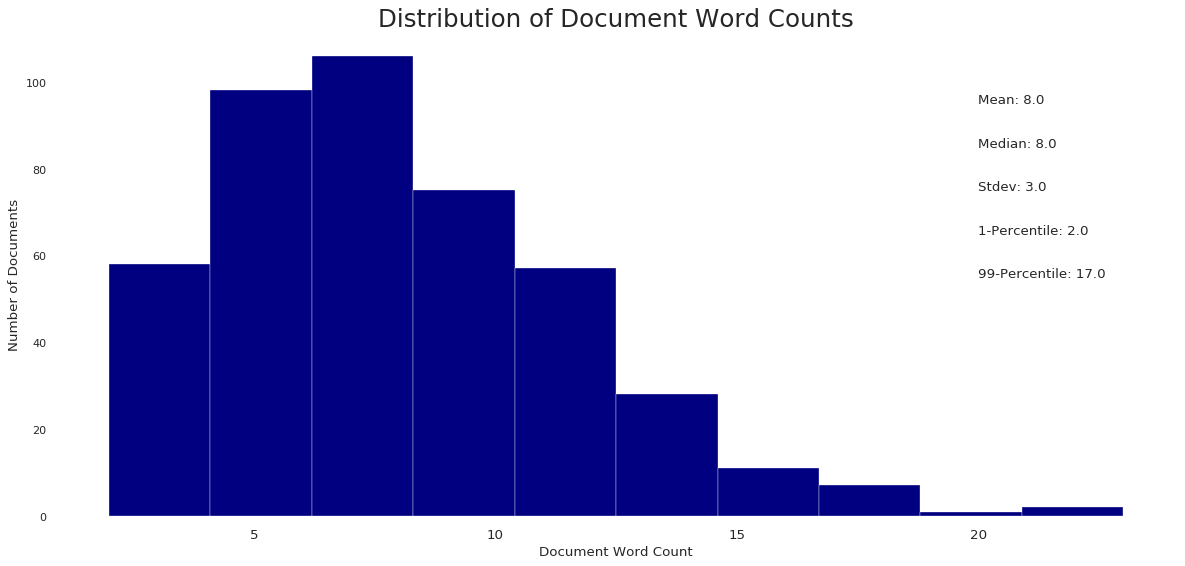

In [47]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

#### Word counts of topic keywords

In [31]:
# Formatting
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = list()
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])
data = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

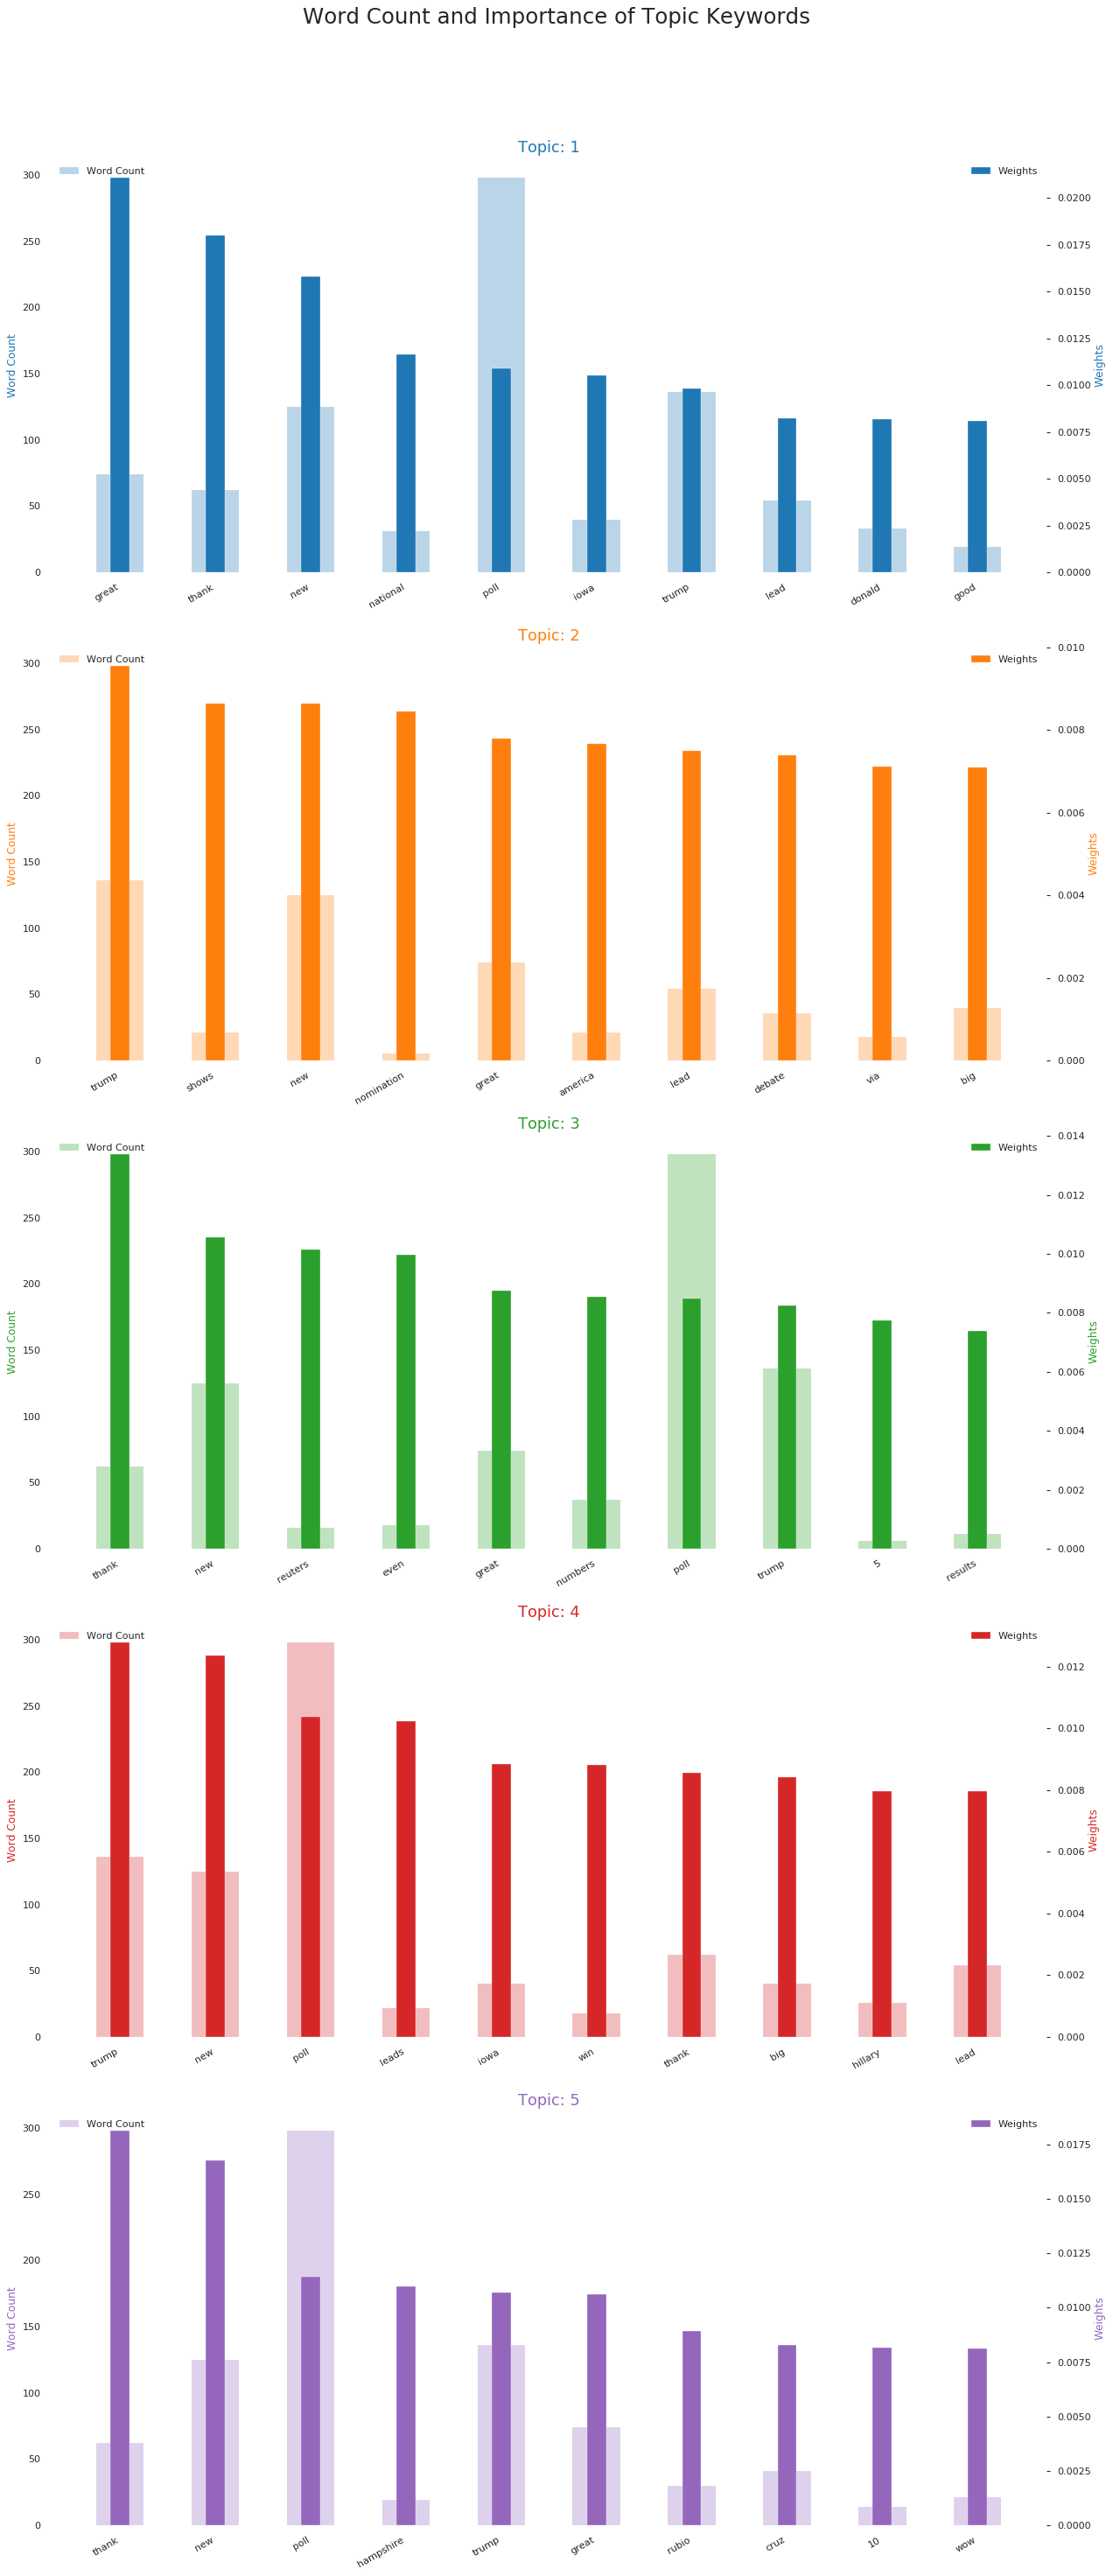

In [48]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 35), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

#### What are the most discussed topics in the tweets?

In [33]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [34]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [35]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [36]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

We will now make two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

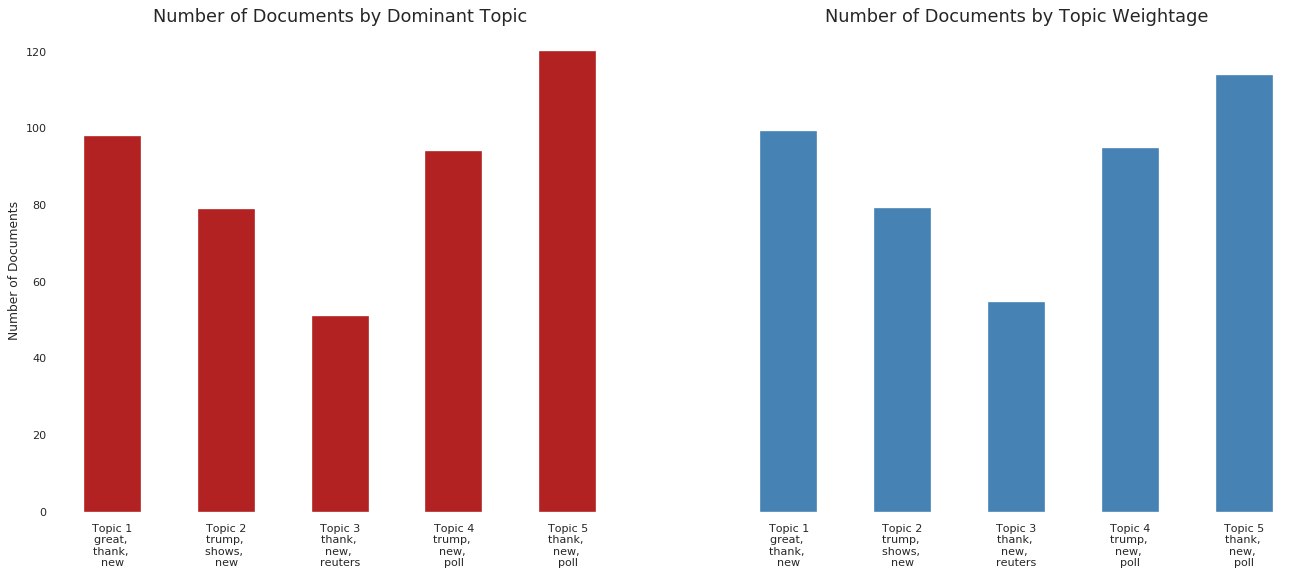

In [49]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

#### Polarity and subjectivity of sentiments

In [38]:
# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity, subjectivity = list(), list()
    for tweet in df[column]:
        blob = TextBlob(tweet)
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

polarity_and_subjectivity(df=df, column='text')

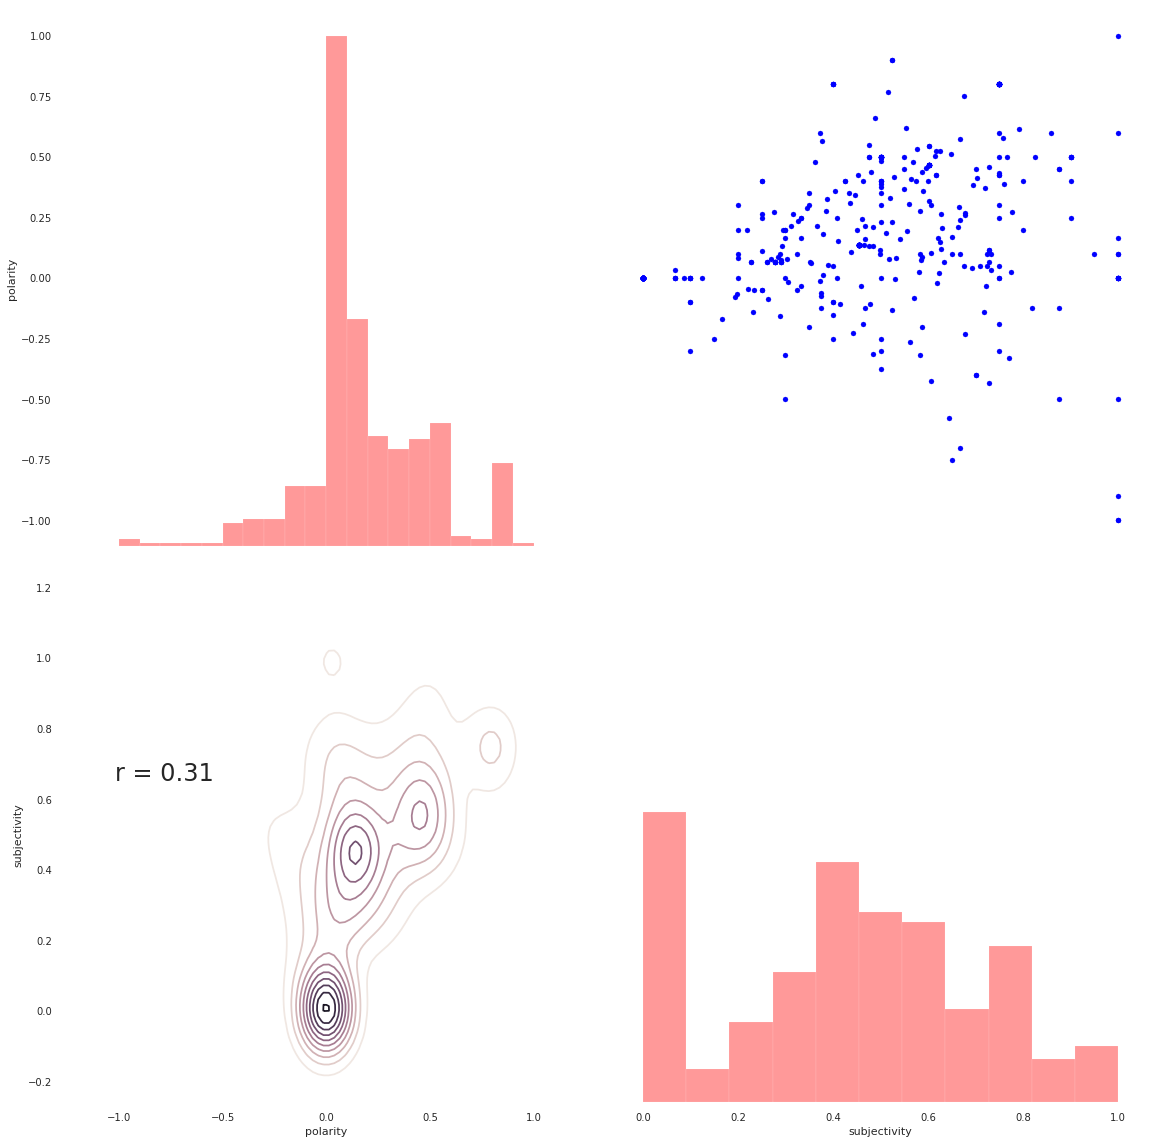

In [41]:
# Correlations
def correlations(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6),
                xycoords=ax.transAxes,
                size=24)

cmap = sns.cubehelix_palette(light=1, dark=.01, hue=.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pairgrid setup
g = sns.PairGrid(df.drop('id', axis=1), height=8)
# Scatterplot on upper triangle
g.map_upper(plt.scatter, s=25, color='blue')
# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color='red')
# Densityplot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap=cmap)
g.map_lower(correlations)

(None, None)

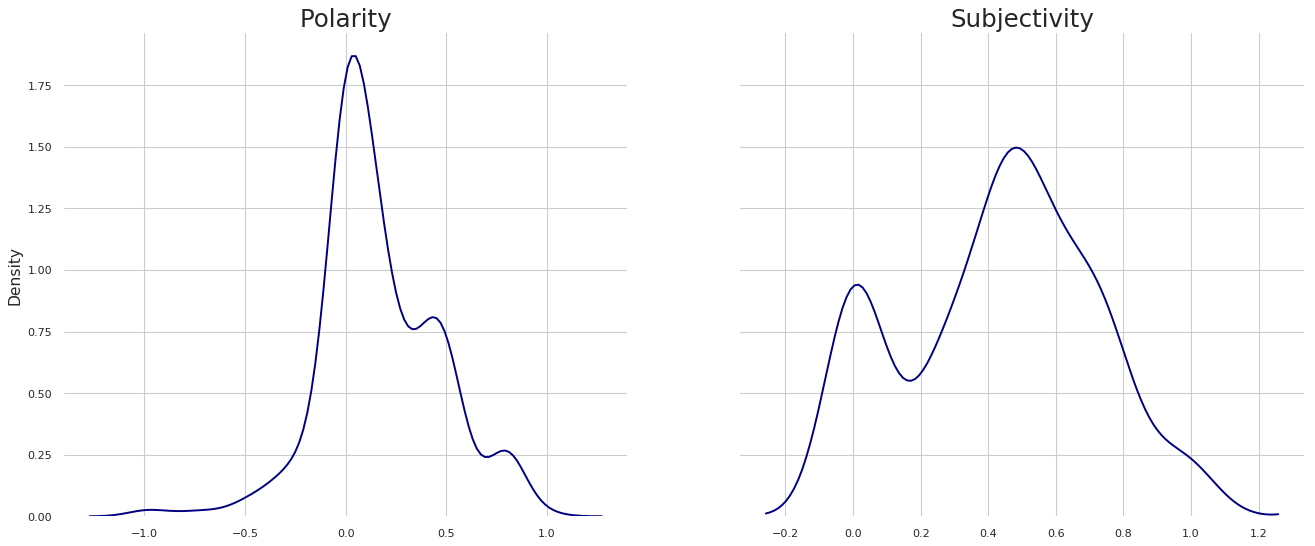

In [50]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(df['polarity'], ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Polarity and subjectivity

(None, None)

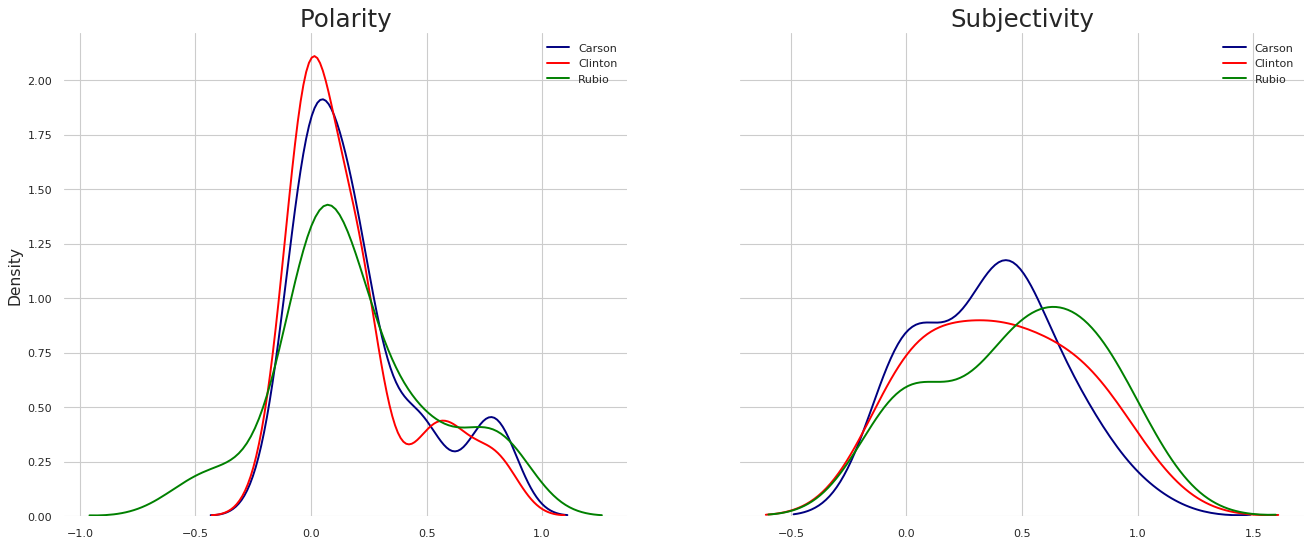

In [51]:
# Comparing subjectivity and polarity between candidates
carson = df.loc[df['text'].str.contains('Carson')]
clinton = df.loc[df['text'].str.contains('Clinton')]
rubio = df.loc[df['text'].str.contains('Rubio')]

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(carson['polarity'], label='Carson', ax=ax1, color='navy', hist=False)
sns.distplot(clinton['polarity'], label='Clinton', ax=ax1, color='red', hist=False)
sns.distplot(rubio['polarity'], label='Rubio', ax=ax1, color='green', hist=False)
sns.distplot(carson['subjectivity'], label='Carson', ax=ax2, color='navy', hist=False)
sns.distplot(clinton['subjectivity'], label='Clinton', ax=ax2, color='red', hist=False)
sns.distplot(rubio['subjectivity'], label='Rubio', ax=ax2, color='green', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Time series of polarity and subjectivity

In [44]:
# Creating time series objects
# Polarity
carson_polarity = ts.create_series(carson, 'created_at', 'polarity')
clinton_polarity = ts.create_series(clinton, 'created_at', 'polarity')
rubio_polarity = ts.create_series(rubio, 'created_at', 'polarity')

# Subjectivity
carson_subjectivity = ts.create_series(carson, 'created_at', 'subjectivity')
clinton_subjectivity = ts.create_series(clinton, 'created_at', 'subjectivity')
rubio_subjectivity = ts.create_series(rubio, 'created_at', 'subjectivity')

In [53]:
def smooth(x,window_len=11,window='hanning'):
    '''smooth the data using a window with requested size.
    
    NB: Taken from scipy cookbook.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    '''

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    return np.convolve(w/w.sum(), s, mode='valid')

(None, None)

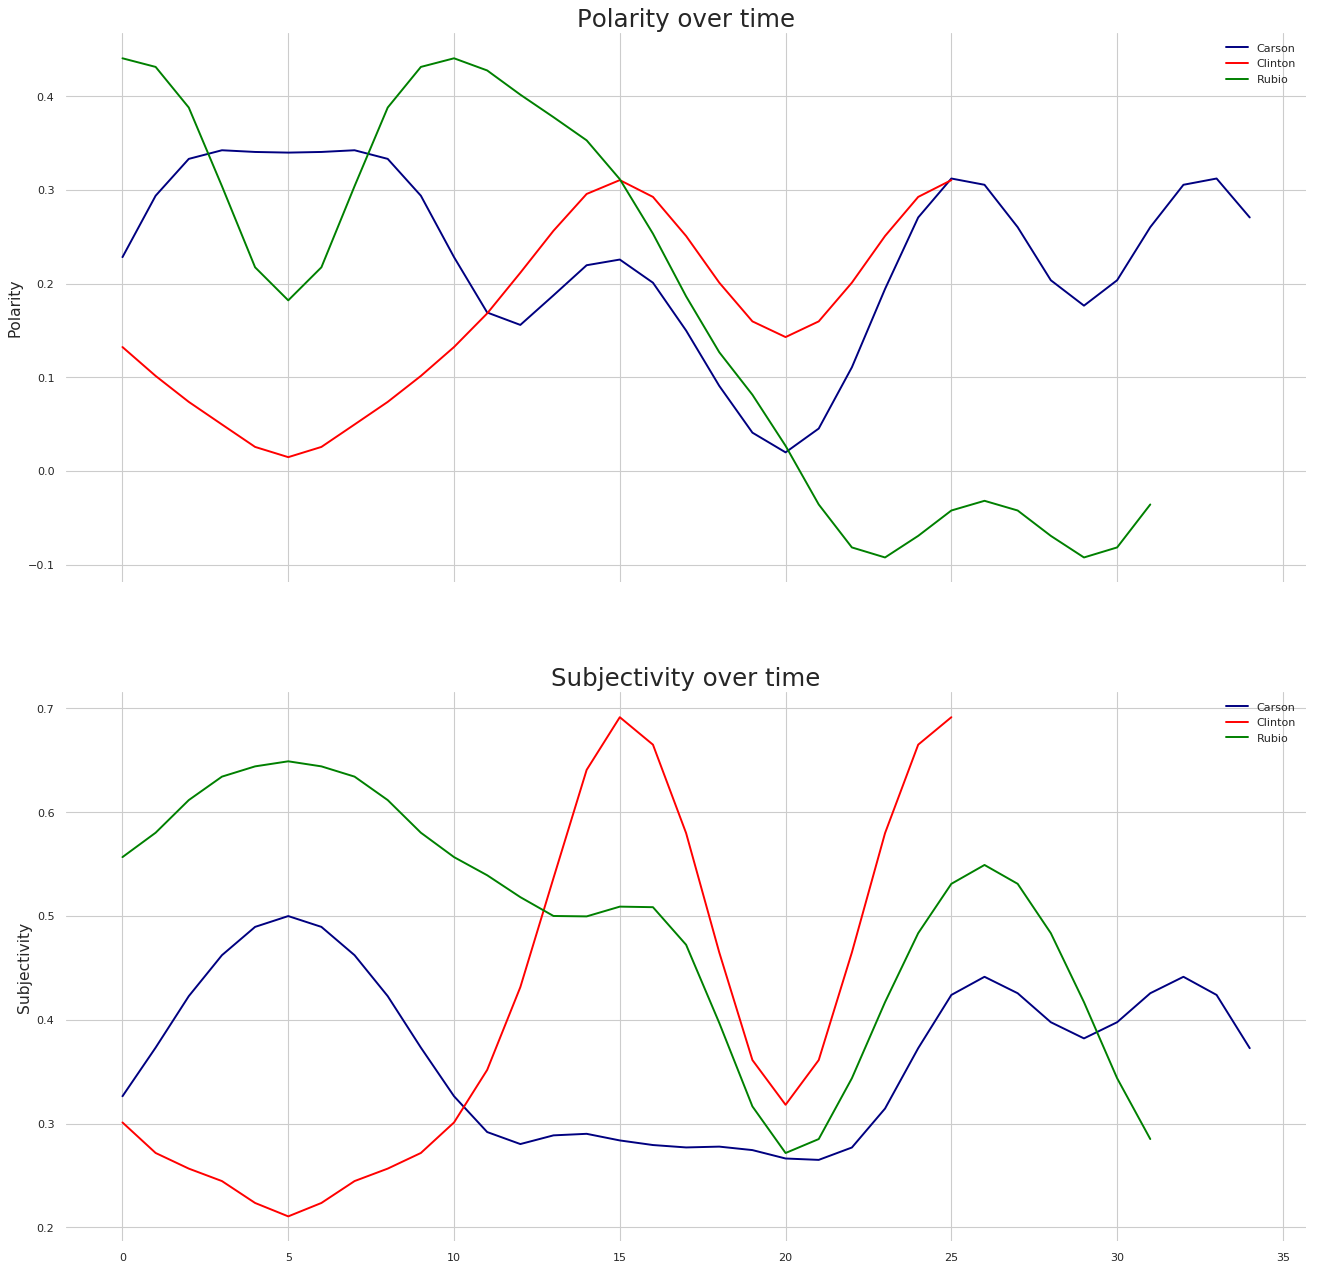

In [54]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=80, sharex=True)
sns.lineplot(data=smooth(carson_polarity), label='Carson', color='navy', ax=ax1)
sns.lineplot(data=smooth(clinton_polarity), label='Clinton', color='red', ax=ax1)
sns.lineplot(data=smooth(rubio_polarity), label='Rubio', color='green', ax=ax1)
sns.lineplot(data=smooth(carson_subjectivity), label='Carson', color='navy', ax=ax2)
sns.lineplot(data=smooth(clinton_subjectivity), label='Clinton', color='red', ax=ax2)
sns.lineplot(data=smooth(rubio_subjectivity), label='Rubio', color='green', ax=ax2)
ax1.set_title('Polarity over time', fontsize=22)
ax2.set_title('Subjectivity over time', fontsize=22)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_ylabel('Subjectivity', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()